### [사용모델 : 3가지]
* 1) monologg/koelectra-base-v3-discriminator
* 2) bert-base-multilingual-cased
* 3) monologg/koelectra-base-v3-discriminator

## 1. 라이브러리 및 데이터 불러오기

In [24]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import time
import datetime

In [ ]:
import pandas as pd
import torch
from torch.nn import functional
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, ElectraForSequenceClassification, AdamW
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
from transformers import BertForSequenceClassification, AdamW, BertConfig
# GPU 사용
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_excel('/content/drive/MyDrive/train_data2.xlsx')
test = pd.read_excel('/content/drive/MyDrive/test_data.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. 데이터 전처리

In [ ]:
#모델에 맞게 형식 변환  
data['doc'] = "[CLS] " + data['doc'] + " [SEP]"
# data[data['doc'].notnull()]
data

,doc,label
0,[CLS] 손경식 회장 해외사업 공격적 확장 성장 가속화 [SEP],1
1,[CLS] 신입사원 연차 생기고 공공기관 채용 역대 최대 [SEP],1
2,[CLS] 2018년 채용연계형 인턴채용 문 열렸다 [SEP],1
3,[CLS] 무술년 채용연계형 인턴채용 스타트 [SEP],1
4,[CLS] 그냥 쉬었다 청년 30만명 역대 최고치 [SEP],0
...,...,...
193944,[CLS] 디케이드 다음에 더블 다음에 오즈인데 더블은 조금밖에 안나오네요. [SEP],1
193945,[CLS] 인간이 문제지. 소는 뭔죄인가. [SEP],0
193946,[CLS] 이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다? [SEP],0
193947,[CLS] 청춘 영화의 최고봉.방황과 우울했던 날들의 자화상 [SEP],1


In [ ]:
def convert_input_data(sentences):
    tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 200
    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # 어텐션 마스크 초기화
    attention_masks = []
    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return input_ids, attention_masks

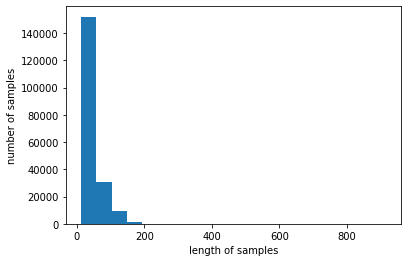

In [ ]:
plt.hist([len(doc) for doc in data['doc']], bins = 20)
plt.xlabel('length of samples'), plt.ylabel('number of samples');

In [ ]:
input_ids, attention_masks = convert_input_data(data.doc)

Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

## 3. 모델 생성

In [ ]:
# 훈련셋과 검증셋으로 분리
train_x, val_x, train_y, val_y = train_test_split(input_ids, data.label.values, random_state=1004, test_size=0.2)
train_mask, val_mask, _, _ = train_test_split(attention_masks, input_ids, random_state=1004, test_size=0.2)

In [ ]:
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)
train_mask = torch.tensor(train_mask)
val_x = torch.tensor(val_x)
val_y = torch.tensor(val_y)
val_mask = torch.tensor(val_mask)				

In [ ]:
batch_size = 32
train_data = TensorDataset(train_x, train_mask, train_y)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

val_data = TensorDataset(val_x, val_mask, val_y)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

In [ ]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: A100-SXM4-40GB


In [ ]:
# 분류를 위한 koelectra_v3 모델 생성
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator")
model.cuda()

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
epochs = 10
total_steps = len(train_dataloader) * epochs

optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

NameError: ignored

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## 4. 모델 학습

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

loss_list, acc_list = [], []
for epoch_i in tqdm(range(0, epochs)):
    # 시작 시간 설정
    t0 = time.time()
    # 로스 초기화
    total_loss = 0
    # 훈련모드
    model.train()
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        # Forward 수행                
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        # Backward 수행으로 그래디언트 계산
        loss.backward()
        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()
        # 스케줄러로 학습률 감소
        scheduler.step()
        # 그래디언트 초기화
        model.zero_grad()
    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)
    loss_list.append(avg_train_loss)            
   
    # 평가모드
    model.eval()
    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in val_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            # 로스 구함
        logits = outputs[0]
        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    acc_list.append(round(eval_accuracy/nb_eval_steps, 2))

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
PATH = '/content/drive/MyDrive/'
torch.save(model, PATH + 'model.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict()}, PATH + 'all.tar')  

RuntimeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 5. 모델 검증

Accuracy : 0.85


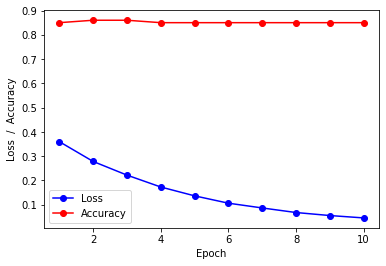

In [ ]:
epoch = range(1, epochs+1) 
plt.plot(epoch, loss_list,'-bo', label='Loss')
plt.plot(epoch, acc_list, '-ro', label='Accuracy')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('Loss  /  Accuracy');
print(f'Accuracy : {round(eval_accuracy/nb_eval_steps, 2)}')

## 6. 전이학습

In [29]:
# optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)
PATH = '/content/drive/MyDrive/'
model = torch.load(PATH + 'model.pt')  # 모델 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/Koelectra_base.pt'))

checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


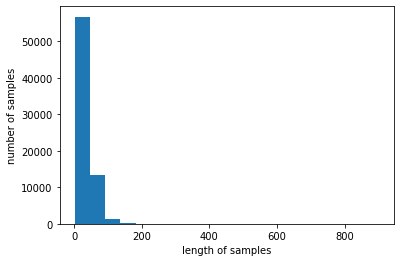

In [30]:
plt.hist([len(doc) for doc in test['doc']], bins = 20)
plt.xlabel('length of samples'), plt.ylabel('number of samples');

In [31]:
def test_sentences(sentences):
    model.eval()
    # 문장을 입력 데이터로 변환
    input_ids, attention_masks = convert_input_data(sentences)
    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)
    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # 로스 구함
    logits = outputs[0]
    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    return logits     

In [ ]:
test['predict'] = 0 
for idx in range(len(test)):
    logit = test_sentences(test.doc[idx])
    test.loc[idx, 'predicted'] = np.argmax(logit)

test

Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

In [ ]:
test.to_csv("predict_koelec3.csv") # header=False, index=False

In [ ]:
# predict= pd.read_csv("./kopredict_koelec3.csv", encoding='CP949')
# predict.head(10)